# 07 Experiment Tracking Class

In [19]:
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn
from going_modular import engine, data_loaders
from going_modular.engine import train_step, test_step
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import os
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random
import requests
import sklearn
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from torchinfo import summary
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import Accuracy, ConfusionMatrix
import torchvision
from torchvision import datasets

from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import Tuple, Dict, List
writer = SummaryWriter()
import zipfile



In [2]:
# see torch and torch vision plus
print (torch.__version__)
print (torchvision.__version__)

2.3.0
0.18.0


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def set_seeds (seed: int=42):
    """_summary_

    Args:
        seed (int, optional): _description_. Defaults to 42.
    """ 
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)   

In [4]:
# do helder function
def download_data (source: str,
                   destination: str,
                   data_dir: str = '../data',
                   remove_source: bool = True) -> Path:
    """_summary_

    Args:
        soure (str): _description_
        destination (str): _description_
        remove_source (bool, optional): _description_. Defaults to True.

    Returns:
        Path: _description_
    """    

    data_path = Path (data_dir)
    image_path = data_path / destination
    if image_path.is_dir():
        print (f' {image_path} directory exists skipping download')
    else:
        print (f'[INFO] creating {image_path}')
        image_path.mkdir(parents = True, exist_ok = True)
        target_file = Path(source).name
        with open(data_path/ target_file, 'wb') as f:
            request = requests.get(source)
            print (f'[INFO] downloading {target_file} from {source}')
            f.write (request.content)
        with zipfile.ZipFile(data_path/target_file, 'r') as zip_ref:
            print (f'[INFO] Unsipping {target_file}')
            zip_ref.extractall(image_path)

        if remove_source:
            os.remove (data_path/target_file)
   
    return image_path


In [5]:
# data_path = Path('../data')
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi_1")

 ..\data\pizza_steak_sushi_1 directory exists skipping download


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
# manual data loader
image_path = Path('../data/pizza_steak_sushi_1')
train_dir = image_path /'train'
test_dir = image_path/'test'

normalize = transforms.Normalize(mean =[0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])
manual_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
])

train_dataloader, test_dataloader, class_names = data_loaders.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = 32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1cabcb9f610>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# auto data laoder
image_path = Path('../data/pizza_steak_sushi_1')
train_dir = image_path /'train'
test_dir = image_path/'test'

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
automatic_transforms = weights.transforms()
print (f'Auto transforms: {automatic_transforms}')

train_dataloader, test_dataloader, class_names= data_loaders.create_dataloaders(
    train_dir=train_dir,
    test_dir = test_dir,
    transform=automatic_transforms,
    batch_size = 32
)

train_dataloader, test_dataloader, class_names

Auto transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x1cabcbb3e50>,
 ['pizza', 'steak', 'sushi'])

## get pretrained model.



In [9]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_B0 = torchvision.models.efficientnet_b0(weights = weights).to(device)
model_B0

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [10]:
for param in model_B0.features.parameters():
    param.requires_grad = False
    
set_seeds()

model_B0.classifier= torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features = len(class_names),
              bias = True).to(device)
)

In [11]:
from torchinfo import summary
summary(model_B0,
        input_size = (32, 3, 224, 224),
        verbose = 0,
        col_names = ['input_size', 'output_size', 'num_params','trainable' ],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Train model

In [12]:
# start training
loss_fn = nn.CrossEntropyLoss()
optimizer    = torch.optim.Adam(model_B0.parameters(), lr=0.001)

In [16]:
writer = SummaryWriter()

### create  writer



In [69]:
def create_writer(experiment_name: str,
                model_name:str,
                extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():

    """_summary_
    """    
    from datetime import datetime
    import os

    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        log_dir = os.path.join('runs', timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.john ('runs', timestamp, experiment_name, model_name)

    print (f'[INFO] Created SummaryWriter, saving to: {log_dir}..')
    
    return SummaryWriter(log_dir = log_dir)

In [26]:
# import torch.utils


# def train (model: torch.nn.Module,
#            train_dataloader: torch.utils.data.DataLoader,
#            test_dataloader: torch.utils.data.DataLoader,
#            optimizer: torch.optim.Optimizer,
#            loss_fn: torch.nn.Module,
#            epochs: int,
#            device: torch.device) -> Dict[str, List]:
#     """_summary_

#     Args:
#         model (torch.nn.Module): _description_
#         train_dataloader (torch.utils.data.DataLoader): _description_
#         test_dataloader (torch.utils.data.DataLoader): _description_
#         optimizer (torch.optim.Optimizer): _description_
#         loss_fn (torch.nn.Module): _description_
#         epochs (int): _description_
#         device (torch.device): _description_

#     Returns:
#         Dict[str, List]: _description_
#     """   

#     results = {'train_loss':[],
#               'train_acc': [],
#               'test_loss': [],
#               'test_acc': []} 
    
#     for epoch in tqdm(range(epochs)):
#         train_loss, train_acc = train_step(model=model,
#                                            dataloader= train_dataloader,
#                                            loss_fn = loss_fn,
#                                            optimizer=optimizer,
#                                            device = device)
        
#         test_loss, test_acc = test_step(model=model,
#                                         dataloader = test_dataloader,
#                                         loss_fn=loss_fn,
#                                         device=device)
        
#         print(
#             f'Epoch: {epoch + 1} |'
#             f'train_loss: {train_loss:.4f} |'
#             f'train_acc: {train_acc:.4f} |'
#             f'test_lossL {test_loss:.4f} | '
#             f'test_acc: {test_acc:.4f}'
#         )

#         results['test_loss'].append(train_loss)
#         results['train_acc'].append(train_acc)
#         results['test_loss'].append(test_loss)
#         results['test_acc'].append(test_acc)

#         writer.add_scalars (main_tag = 'Accuracy',
#                             tag_scalar_dict = {'train_acc': train_acc,
#                                                'test_acc': test_acc},
#                                                global_step = epoch)
        
#         writer.add_graph (model= model,
#                           input_to_model=torch.randn(32, 3, 224, 224).to(device))
        
#     writer.close()

#     return results


In [84]:
import torch.utils
import torch.utils.tensorboard


def train (model: torch.nn.Module,
           train_dataloader: torch.utils.data.DataLoader,
           test_dataloader: torch.utils.data.DataLoader,
           optimizer: torch.optim.Optimizer,
           loss_fn: torch.nn.Module,
           epochs: int,
           device: torch.device,
           writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    """_summary_

    Args:
        model (torch.nn.Module): _description_
        train_dataloader (torch.utils.data.DataLoader): _description_
        test_dataloader (torch.utils.data.DataLoader): _description_
        optimizer (torch.optim.Optimizer): _description_
        loss_fn (torch.nn.Module): _description_
        epochs (int): _description_
        device (torch.device): _description_

    Returns:
        Dict[str, List]: _description_
    """   

    results = {'train_loss':[],
              'train_acc': [],
              'test_loss': [],
              'test_acc': []} 
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader= train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer=optimizer,
                                           device = device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader = test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        
        print(
            f'Epoch: {epoch + 1} |'
            f'train_loss: {train_loss:.4f} |'
            f'train_acc: {train_acc:.4f} |'
            f'test_lossL {test_loss:.4f} | '
            f'test_acc: {test_acc:.4f}'
        )

        results['test_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

        if writer:
            writer.add_scalars (main_tag = 'Accuracy',
                                tag_scalar_dict = {'train_acc': train_acc,
                                                'test_acc': test_acc},
                                                global_step = epoch)
            writer.add_scalars(main_tag = 'Loss',
                                tag_scalar_dict = {'train_loss':train_loss,
                                                 'test_acc':test_acc},
                                global_step=epoch)
            
            writer.add_graph (model= model,
                            input_to_model=torch.randn(32, 3, 224, 224).to(device))
        
    writer.close()

    return results


In [27]:
set_seeds()
results = train (model = model_B0,
                 train_dataloader=train_dataloader,
                 test_dataloader=test_dataloader,
                 optimizer=optimizer,
                 loss_fn=loss_fn,
                 epochs = 5,
                 device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 0.8159 |train_acc: 0.8398 |test_lossL 0.8180 | test_acc: 0.7955


 20%|██        | 1/5 [00:04<00:18,  4.58s/it]

Epoch: 2 |train_loss: 0.8094 |train_acc: 0.6719 |test_lossL 0.7170 | test_acc: 0.8258


 40%|████      | 2/5 [00:09<00:13,  4.60s/it]

Epoch: 3 |train_loss: 0.7216 |train_acc: 0.7734 |test_lossL 0.6179 | test_acc: 0.8759


 60%|██████    | 3/5 [00:13<00:09,  4.56s/it]

Epoch: 4 |train_loss: 0.6161 |train_acc: 0.7383 |test_lossL 0.6252 | test_acc: 0.8561


 80%|████████  | 4/5 [00:18<00:04,  4.54s/it]

Epoch: 5 |train_loss: 0.6619 |train_acc: 0.7422 |test_lossL 0.6354 | test_acc: 0.8258


100%|██████████| 5/5 [00:22<00:00,  4.54s/it]


## Dowlad dataset

In [29]:
data_10_percent_path = Path('../data/pizza_steak_sushi')
data_20_percent_path = Path('../data/pizza_steak_sushi_20_percent')
train_dir_10_percent = data_10_percent_path / 'train'
train_dir_20_percent = data_20_percent_path / 'train'
test_dir = data_10_percent_path / 'test'
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: ..\data\pizza_steak_sushi\train
Training directory 20%: ..\data\pizza_steak_sushi_20_percent\train
Testing directory: ..\data\pizza_steak_sushi\test


In [31]:
normalize = transforms.Normalize(mean = [0.485, 0.465, 0.406],
                                 std=[0.229, 0.224, 0.225])

simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [33]:
BATCH_SIZE =  32

train_dataloader_10_percent, test_dataloader, class_names =data_loaders.create_dataloaders(
    train_dir = train_dir_10_percent,
    test_dir = test_dir,
    transform = simple_transform,
    batch_size=BATCH_SIZE
) 

train_dataloader_20_percent, test_dataloader, class_names =data_loaders.create_dataloaders(
    train_dir = train_dir_20_percent,
    test_dir = test_dir,
    transform = simple_transform,
    batch_size=BATCH_SIZE
) 
# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [38]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

print(summary (model=effnetb2,
         input_size = (32, 3, 224, 224),
         col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
         col_width = 20,
         row_settings = ['var_names']
         ))

print (f'number of in_features ot final layer of EfficentB2 {len(effnetb2.classifier.state_dict()["1.weight"][0])}')
# print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [55]:
OUT_FEATUREs = len (class_names)
def create_effnetb0():
    weignts = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad=False

    set_seeds
    
    model.classifier=nn.Sequential(
        nn.Dropout(p = 0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATUREs)
    ).to(device)

    model.name = 'effnetb0'
    print (f'[INFO] Crated new {model.name} model')
    return model

def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad=False
    
    set_seeds()

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATUREs)
    ).to(device)

    model.name = 'effnetb2'
    print (f'[INFO] Creted new {model.name} model')

    return model


In [50]:
effnetb0 = create_effnetb0()

summary(model=effnetb0,
        input_size = (32, 3, 224, 224 ),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings= ['var_names']
)


[INFO] Crated new effnetb0 model


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [57]:
effnetb2 = create_effnetb2()

summary(model=effnetb2,
        input_size = (32, 3, 224, 224 ),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings= ['var_names']
)


[INFO] Creted new effnetb2 model


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Create Experiments and training code

In [58]:
num_epochs = [5, 10]
models = ['effnetb0', 'effnetb2']
train_dataloaders = {'data_10_percent': train_dataloader_10_percent,
                     'data_20_percent': train_dataloader_20_percent}

In [85]:
%%time
from going_modular.utils import save_model
set_seeds (seed=42)
experiment_number = 0

for dataloader_name, train_dataloader in train_dataloaders.items():
    for epochs in num_epochs:
        for model_name in models:
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            if model_name == 'effnetb0':
                model = create_effnetb0()
            else:
                model = create_effnetb2()

            loss_fn = nn.CrossEntropyLoss()
            optimizer=torch.optim.Adam (params=model.parameters(), lr= 0.001)

            train(model= model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs = epochs,
                device = device,
                writer=create_writer (experiment_name = dataloader_name,
                                        model_name = model_name,
                                        extra = f'{epochs}_epochs'))

            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model (model=model,
                target_dir = 'models',
                model_name = save_filepath)

            print ("_"*50 + "\n")
           

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Crated new effnetb0 model
[INFO] Created SummaryWriter, saving to: runs\2024-09-17\data_10_percent\effnetb0\5_epochs..


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 1.0303 |train_acc: 0.4375 |test_lossL 0.8738 | test_acc: 0.6629


 20%|██        | 1/5 [00:06<00:24,  6.04s/it]

Epoch: 2 |train_loss: 0.8515 |train_acc: 0.6406 |test_lossL 0.6976 | test_acc: 0.8561


 40%|████      | 2/5 [00:12<00:18,  6.28s/it]

Epoch: 3 |train_loss: 0.7416 |train_acc: 0.8164 |test_lossL 0.6846 | test_acc: 0.8049


 60%|██████    | 3/5 [00:18<00:12,  6.38s/it]

Epoch: 4 |train_loss: 0.7355 |train_acc: 0.6875 |test_lossL 0.6810 | test_acc: 0.7737


 80%|████████  | 4/5 [00:25<00:06,  6.29s/it]

Epoch: 5 |train_loss: 0.6021 |train_acc: 0.8906 |test_lossL 0.5686 | test_acc: 0.8362


100%|██████████| 5/5 [00:31<00:00,  6.27s/it]


[INFO] Saving model to: models\07_effnetb0_data_10_percent_5_epochs.pth
__________________________________________________

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Creted new effnetb2 model
[INFO] Created SummaryWriter, saving to: runs\2024-09-17\data_10_percent\effnetb2\5_epochs..


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 1.0913 |train_acc: 0.3828 |test_lossL 0.9553 | test_acc: 0.6506


 20%|██        | 1/5 [00:08<00:33,  8.39s/it]

Epoch: 2 |train_loss: 0.9094 |train_acc: 0.6328 |test_lossL 0.9069 | test_acc: 0.6619


 40%|████      | 2/5 [00:16<00:24,  8.06s/it]

Epoch: 3 |train_loss: 0.8439 |train_acc: 0.6914 |test_lossL 0.8123 | test_acc: 0.8153


 60%|██████    | 3/5 [00:24<00:16,  8.18s/it]

Epoch: 4 |train_loss: 0.7191 |train_acc: 0.8477 |test_lossL 0.6987 | test_acc: 0.9072


 80%|████████  | 4/5 [00:31<00:07,  7.89s/it]

Epoch: 5 |train_loss: 0.7256 |train_acc: 0.7461 |test_lossL 0.6513 | test_acc: 0.8864


100%|██████████| 5/5 [00:40<00:00,  8.08s/it]


[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
__________________________________________________

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Crated new effnetb0 model
[INFO] Created SummaryWriter, saving to: runs\2024-09-17\data_10_percent\effnetb0\10_epochs..


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 1.0093 |train_acc: 0.5391 |test_lossL 0.9694 | test_acc: 0.4886


 10%|█         | 1/10 [00:06<01:01,  6.78s/it]

Epoch: 2 |train_loss: 0.8049 |train_acc: 0.7539 |test_lossL 0.8491 | test_acc: 0.5076


 20%|██        | 2/10 [00:14<00:57,  7.24s/it]

Epoch: 3 |train_loss: 0.8094 |train_acc: 0.6211 |test_lossL 0.7229 | test_acc: 0.7225


 30%|███       | 3/10 [00:20<00:48,  6.93s/it]

Epoch: 4 |train_loss: 0.6662 |train_acc: 0.7461 |test_lossL 0.5905 | test_acc: 0.8864


 40%|████      | 4/10 [00:28<00:42,  7.06s/it]

Epoch: 5 |train_loss: 0.6128 |train_acc: 0.7734 |test_lossL 0.5609 | test_acc: 0.8968


 50%|█████     | 5/10 [00:34<00:33,  6.79s/it]

Epoch: 6 |train_loss: 0.6080 |train_acc: 0.7852 |test_lossL 0.5181 | test_acc: 0.8759


 60%|██████    | 6/10 [00:41<00:27,  6.80s/it]

Epoch: 7 |train_loss: 0.5019 |train_acc: 0.9453 |test_lossL 0.5028 | test_acc: 0.9072


 70%|███████   | 7/10 [00:47<00:20,  6.73s/it]

Epoch: 8 |train_loss: 0.4533 |train_acc: 0.9492 |test_lossL 0.5425 | test_acc: 0.8759


 80%|████████  | 8/10 [00:54<00:13,  6.59s/it]

Epoch: 9 |train_loss: 0.5009 |train_acc: 0.8164 |test_lossL 0.5357 | test_acc: 0.8864


 90%|█████████ | 9/10 [01:01<00:06,  6.70s/it]

Epoch: 10 |train_loss: 0.4488 |train_acc: 0.9453 |test_lossL 0.5090 | test_acc: 0.9081


100%|██████████| 10/10 [01:07<00:00,  6.76s/it]


[INFO] Saving model to: models\07_effnetb0_data_10_percent_10_epochs.pth
__________________________________________________

[INFO] Experiment number: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Creted new effnetb2 model
[INFO] Created SummaryWriter, saving to: runs\2024-09-17\data_10_percent\effnetb2\10_epochs..


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 1.0913 |train_acc: 0.3828 |test_lossL 0.9553 | test_acc: 0.6506


 10%|█         | 1/10 [00:08<01:18,  8.72s/it]

Epoch: 2 |train_loss: 0.9094 |train_acc: 0.6328 |test_lossL 0.9069 | test_acc: 0.6619


 20%|██        | 2/10 [00:17<01:07,  8.46s/it]

Epoch: 3 |train_loss: 0.8439 |train_acc: 0.6914 |test_lossL 0.8123 | test_acc: 0.8153


 30%|███       | 3/10 [00:26<01:02,  8.89s/it]

Epoch: 4 |train_loss: 0.7191 |train_acc: 0.8477 |test_lossL 0.6987 | test_acc: 0.9072


 40%|████      | 4/10 [00:36<00:56,  9.42s/it]

Epoch: 5 |train_loss: 0.7256 |train_acc: 0.7461 |test_lossL 0.6513 | test_acc: 0.8864


 50%|█████     | 5/10 [00:46<00:47,  9.47s/it]

Epoch: 6 |train_loss: 0.6074 |train_acc: 0.7656 |test_lossL 0.6580 | test_acc: 0.8665


 60%|██████    | 6/10 [00:54<00:36,  9.24s/it]

Epoch: 7 |train_loss: 0.5985 |train_acc: 0.8164 |test_lossL 0.6045 | test_acc: 0.9280


 70%|███████   | 7/10 [01:03<00:26,  8.86s/it]

Epoch: 8 |train_loss: 0.5478 |train_acc: 0.8281 |test_lossL 0.6057 | test_acc: 0.8873


 80%|████████  | 8/10 [01:11<00:17,  8.65s/it]

Epoch: 9 |train_loss: 0.5174 |train_acc: 0.7891 |test_lossL 0.5703 | test_acc: 0.8466


 90%|█████████ | 9/10 [01:19<00:08,  8.41s/it]

Epoch: 10 |train_loss: 0.5072 |train_acc: 0.8203 |test_lossL 0.5620 | test_acc: 0.8977


100%|██████████| 10/10 [01:27<00:00,  8.75s/it]


[INFO] Saving model to: models\07_effnetb2_data_10_percent_10_epochs.pth
__________________________________________________

[INFO] Experiment number: 5
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Crated new effnetb0 model
[INFO] Created SummaryWriter, saving to: runs\2024-09-17\data_20_percent\effnetb0\5_epochs..


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 0.9605 |train_acc: 0.5813 |test_lossL 0.7187 | test_acc: 0.8059


 20%|██        | 1/5 [00:09<00:36,  9.13s/it]

Epoch: 2 |train_loss: 0.7070 |train_acc: 0.7812 |test_lossL 0.5651 | test_acc: 0.9072


 40%|████      | 2/5 [00:17<00:26,  8.89s/it]

Epoch: 3 |train_loss: 0.5367 |train_acc: 0.8583 |test_lossL 0.5317 | test_acc: 0.8977


 60%|██████    | 3/5 [00:28<00:19,  9.53s/it]

Epoch: 4 |train_loss: 0.4842 |train_acc: 0.8604 |test_lossL 0.4323 | test_acc: 0.9280


 80%|████████  | 4/5 [00:36<00:09,  9.16s/it]

Epoch: 5 |train_loss: 0.4835 |train_acc: 0.8375 |test_lossL 0.4096 | test_acc: 0.8873


100%|██████████| 5/5 [00:45<00:00,  9.15s/it]


[INFO] Saving model to: models\07_effnetb0_data_20_percent_5_epochs.pth
__________________________________________________

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Creted new effnetb2 model
[INFO] Created SummaryWriter, saving to: runs\2024-09-17\data_20_percent\effnetb2\5_epochs..


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 0.9819 |train_acc: 0.5604 |test_lossL 0.7773 | test_acc: 0.8049


 20%|██        | 1/5 [00:09<00:38,  9.74s/it]

Epoch: 2 |train_loss: 0.7176 |train_acc: 0.8000 |test_lossL 0.6583 | test_acc: 0.8561


 40%|████      | 2/5 [00:19<00:28,  9.66s/it]

Epoch: 3 |train_loss: 0.5791 |train_acc: 0.8729 |test_lossL 0.5580 | test_acc: 0.9280


 60%|██████    | 3/5 [00:28<00:19,  9.52s/it]

Epoch: 4 |train_loss: 0.5314 |train_acc: 0.8354 |test_lossL 0.5131 | test_acc: 0.9280


 80%|████████  | 4/5 [00:38<00:09,  9.60s/it]

Epoch: 5 |train_loss: 0.4884 |train_acc: 0.8646 |test_lossL 0.4497 | test_acc: 0.9384


100%|██████████| 5/5 [00:49<00:00,  9.81s/it]


[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
__________________________________________________

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Crated new effnetb0 model
[INFO] Created SummaryWriter, saving to: runs\2024-09-17\data_20_percent\effnetb0\10_epochs..


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 0.9938 |train_acc: 0.5271 |test_lossL 0.7426 | test_acc: 0.7850


 10%|█         | 1/10 [00:10<01:32, 10.30s/it]

Epoch: 2 |train_loss: 0.7070 |train_acc: 0.8125 |test_lossL 0.5915 | test_acc: 0.8665


 20%|██        | 2/10 [00:20<01:23, 10.46s/it]

Epoch: 3 |train_loss: 0.6253 |train_acc: 0.7833 |test_lossL 0.5223 | test_acc: 0.8873


 30%|███       | 3/10 [00:30<01:12, 10.30s/it]

Epoch: 4 |train_loss: 0.4984 |train_acc: 0.8625 |test_lossL 0.4551 | test_acc: 0.9176


 40%|████      | 4/10 [00:40<01:00, 10.02s/it]

Epoch: 5 |train_loss: 0.4510 |train_acc: 0.9021 |test_lossL 0.3735 | test_acc: 0.9176


 50%|█████     | 5/10 [00:50<00:49,  9.97s/it]

Epoch: 6 |train_loss: 0.4582 |train_acc: 0.8438 |test_lossL 0.4034 | test_acc: 0.9081


 60%|██████    | 6/10 [01:00<00:40, 10.07s/it]

Epoch: 7 |train_loss: 0.4402 |train_acc: 0.8729 |test_lossL 0.3124 | test_acc: 0.9176


 70%|███████   | 7/10 [01:10<00:30, 10.05s/it]

Epoch: 8 |train_loss: 0.3531 |train_acc: 0.9104 |test_lossL 0.3456 | test_acc: 0.9489


 80%|████████  | 8/10 [01:22<00:21, 10.61s/it]

Epoch: 9 |train_loss: 0.3604 |train_acc: 0.8854 |test_lossL 0.2995 | test_acc: 0.9384


 90%|█████████ | 9/10 [01:31<00:10, 10.12s/it]

Epoch: 10 |train_loss: 0.3644 |train_acc: 0.8500 |test_lossL 0.2996 | test_acc: 0.9384


100%|██████████| 10/10 [01:41<00:00, 10.13s/it]


[INFO] Saving model to: models\07_effnetb0_data_20_percent_10_epochs.pth
__________________________________________________

[INFO] Experiment number: 8
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Creted new effnetb2 model
[INFO] Created SummaryWriter, saving to: runs\2024-09-17\data_20_percent\effnetb2\10_epochs..


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 0.9819 |train_acc: 0.5604 |test_lossL 0.7773 | test_acc: 0.8049


 10%|█         | 1/10 [00:10<01:35, 10.57s/it]

Epoch: 2 |train_loss: 0.7176 |train_acc: 0.8000 |test_lossL 0.6583 | test_acc: 0.8561


 20%|██        | 2/10 [00:20<01:20, 10.03s/it]

Epoch: 3 |train_loss: 0.5791 |train_acc: 0.8729 |test_lossL 0.5580 | test_acc: 0.9280


 30%|███       | 3/10 [00:29<01:09,  9.86s/it]

Epoch: 4 |train_loss: 0.5314 |train_acc: 0.8354 |test_lossL 0.5131 | test_acc: 0.9280


 40%|████      | 4/10 [00:39<00:58,  9.75s/it]

Epoch: 5 |train_loss: 0.4884 |train_acc: 0.8646 |test_lossL 0.4497 | test_acc: 0.9384


 50%|█████     | 5/10 [00:49<00:49,  9.89s/it]

Epoch: 6 |train_loss: 0.3798 |train_acc: 0.9167 |test_lossL 0.4661 | test_acc: 0.8977


 60%|██████    | 6/10 [00:59<00:39,  9.88s/it]

Epoch: 7 |train_loss: 0.3517 |train_acc: 0.9354 |test_lossL 0.4193 | test_acc: 0.9384


 70%|███████   | 7/10 [01:09<00:29,  9.99s/it]

Epoch: 8 |train_loss: 0.3208 |train_acc: 0.9375 |test_lossL 0.4154 | test_acc: 0.9280


 80%|████████  | 8/10 [01:21<00:21, 10.51s/it]

Epoch: 9 |train_loss: 0.3426 |train_acc: 0.8875 |test_lossL 0.4337 | test_acc: 0.8674


 90%|█████████ | 9/10 [01:33<00:11, 11.05s/it]

Epoch: 10 |train_loss: 0.3785 |train_acc: 0.8604 |test_lossL 0.3763 | test_acc: 0.9489


100%|██████████| 10/10 [01:45<00:00, 10.58s/it]


[INFO] Saving model to: models\07_effnetb2_data_20_percent_10_epochs.pth
__________________________________________________

CPU times: total: 21min 7s
Wall time: 8min 52s


In [81]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 87220), started 0:19:46 ago. (Use '!kill 87220' to kill it.)

In [83]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 87220), started 0:25:00 ago. (Use '!kill 87220' to kill it.)

## get best model and predict

In [87]:
best_model_path = 'models/07_effnetb2_data_20_percent_10_epochs.pth'
best_model = create_effnetb2()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Creted new effnetb2 model


<All keys matched successfully>

In [89]:
effnetb2_model_size = Path(best_model_path).stat().st_size//(1024*1024)
print (f'model size = {effnetb2_model_size} mb')

model size = 29 mb


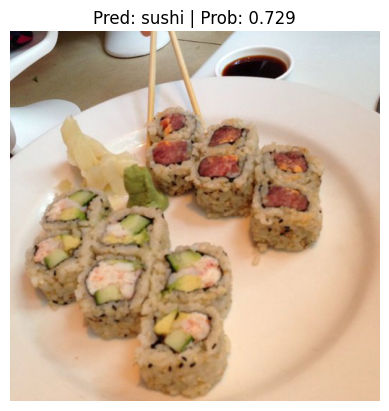

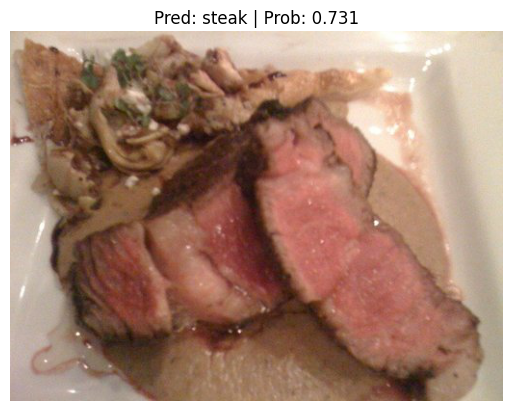

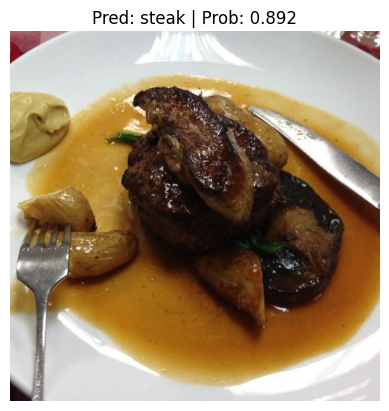

In [99]:
from going_modular.predictions import pred_and_plot_image
num_images_to_plot = 3
test_image_path_list = list (Path(data_10_percent_path/'test').glob('*/*.jpg'))
test_image_path_sample = random.sample (population=test_image_path_list, k = num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model = best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224,224))

data\04-pizza-dad.jpeg exisits


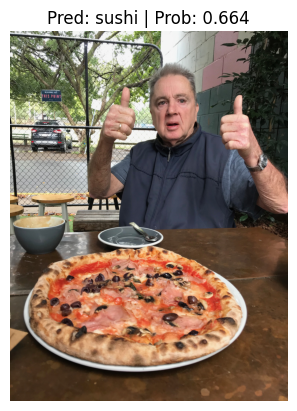

In [100]:
import requests
custom_image_path = Path ("data/04-pizza-dad.jpeg")

if not custom_image_path.is_file():
    with open (custom_image_path, 'wb') as f:
        request = requests("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print (f'downloading {custom_image_path}..')
        f.write (request.content)

else: 
    print (f'{custom_image_path} exisits')

pred_and_plot_image(model =best_model,
                    image_path=custom_image_path,
                     class_names=class_names )